In [ ]:
#kết nối đến google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import library
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout,BatchNormalization
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.models import load_model
from tensorflow.keras.optimizers import SGD
from keras.layers import MaxPool2D
from tensorflow.keras import regularizers
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
#xác định batch_size và kích thước ảnh
batch_size = 64
img_height = 224
img_width = 224
#lấy dữ liệu cho tập train từ google với 80% cho tập train và 20% cho tập validate
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/garbage_classification_splitted1/train',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
# lấy dữ liệu cho tập đánh giá
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/garbage_classification_splitted1/val',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/garbage_classification_splitted1/test',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
 
class_names = train_ds.class_names   # Tên  các lớp của tập dữ liệu
num_classes=len(class_names) #Số lượng lớp của tập dữ liệu
print(class_names)

Found 9926 files belonging to 12 classes.
Found 2479 files belonging to 12 classes.
Found 3110 files belonging to 12 classes.
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [ ]:
import pickle
from sklearn.preprocessing import OneHotEncoder
from os import listdir
import cv2
raw_folder = "/content/drive/MyDrive/garbage_classification/"
def save_data(raw_folder=raw_folder):

    dest_size = (224, 224)
    print("Bắt đầu xử lý ảnh...")

    pixels = []
    labels = []

    # Lặp qua các folder con trong thư mục raw
    for folder in listdir(raw_folder):
        if folder!='.DS_Store':
            print("Folder=",folder)
            # Lặp qua các file trong từng thư mục chứa các em
            for file in listdir(raw_folder  + folder):
                if file!='.DS_Store':
                    print("File=", file)
                    pixels.append( cv2.resize(cv2.imread(raw_folder  + folder +"/" + file),dsize=(224,224)))
                    labels.append( folder)

    pixels = np.array(pixels)
    labels = np.array(labels)#.reshape(-1,1)

    from sklearn.preprocessing import LabelBinarizer
    encoder = LabelBinarizer()
    labels = encoder.fit_transform(labels)
    print(labels)

    file = open('pix.data', 'wb')
    # dump information to that file
    pickle.dump((pixels,labels), file)
    # close the file
    file.close()

    return

def load_data():
    file = open('/content/drive/MyDrive/pix.data', 'rb')

    # dump information to that file
    (pixels, labels) = pickle.load(file)

    # close the file
    file.close()

    print(pixels.shape)
    print(labels.shape)


    return pixels, labels

# save_data()
X,y = load_data()
#random.shuffle(X)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=100)



(15515, 224, 224, 3)
(15515, 12)


In [ ]:


print(X_train.shape)

(12412, 224, 224, 3)


In [ ]:
from keras.applications import VGG16
model = VGG16(weights = 'imagenet', 
  include_top = False,       
  input_shape = (224, 224, 3))

In [ ]:
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
def TopModel(prev_model, num_classes):
  """creates the top or head of the model that will be 
    placed ontop of the bottom layers of the new model"""
  top_model = prev_model.output
  top_model = Flatten(name = "flatten")(top_model) #chuyển dữ liệu về dạng 1 chiều
  top_model = Dense(4096, activation='relu', name='fc1')(top_model) # lớp full connected với 4096 node.
  top_model = BatchNormalization()(top_model)
  top_model = Dropout(0.5)(top_model) # lớp dropout loại bỏ ngẫu nhiên 50% thuộc tính để tránh overfitting.
  top_model = Dense(4096, activation='relu', name='fc2')(top_model)
  top_model = BatchNormalization()(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(num_classes, activation = "softmax", name='output')(top_model) #lớp fullconnected với số node là số lượng lớp của bộ dữ liệu, hàm kích hoạt là softmax
  
  return top_model
    

In [ ]:
num_classes = 12

FC_Head = TopModel(model, num_classes)

newModel = Model(inputs=model.input, outputs=FC_Head)
print(newModel.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
opt = SGD(learning_rate=1e-4, momentum=0.9) #  hàm tối ưu là stochastic gradient descent kết hợp momentum
newModel.compile(loss="sparse_categorical_crossentropy", optimizer='adam',metrics=["accuracy"]) 

In [ ]:
epochs=30

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

checkpoint = ModelCheckpoint("/content/drive/MyDrive/TriTueNhanTao/xoayanh_vgg16.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 4,
                          verbose = 1,
                          restore_best_weights = True)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.1,
    rescale=1./255,
	  width_shift_range=0.1,
    height_shift_range=0.1,
	  horizontal_flip=True,
    brightness_range=[0.2,1.5], fill_mode="nearest")

aug_val = ImageDataGenerator(rescale=1./255)

history= newModel.fit_generator(aug.flow(X_train, y_train, batch_size = 64),
                   validation_data=aug.flow(X_test,y_test,batch_size=64),
                   epochs=epochs,
                   callbacks = [earlystop, checkpoint]) # train model với 50 epochs


In [ ]:
#đánh giá mô hình dựa trên tập test
newModel.evaluate(test_ds)

49/49 [==============================] - 1152s 20s/step - loss: 0.2775 - accuracy: 0.9141


[0.2774944305419922, 0.9141479134559631]

In [ ]:
newModel= keras.models.load_model('/content/drive/MyDrive/TriTueNhanTao/introAiVGG16.h5')

1/1 [==============================] - 1s 650ms/step
np.argmax(x)=7
[[0.00327023 0.00447404 0.00339762 0.10781222 0.00214067 0.00353797
  0.00882956 0.6402098  0.01406027 0.00485047 0.20196669 0.0054505 ]]
0.6402098
1/1 [==============================] - 1s 850ms/step
np.argmax(x)=1
[[2.0421395e-04 7.3760366e-01 1.2603460e-04 1.0675781e-04 2.5792351e-01
  9.5803101e-05 1.9939232e-03 1.1248946e-04 1.0603496e-04 1.4422364e-03
  2.2947871e-04 5.5807322e-05]]
1/1 [==============================] - 1s 790ms/step
np.argmax(x)=11
[[6.9488760e-07 1.5082603e-07 3.3515666e-03 5.4071911e-08 1.2552840e-13
  4.9715047e-04 2.8247308e-04 8.3558700e-07 1.1258524e-01 1.3249027e-07
  8.2580800e-07 8.8328093e-01]]
1/1 [==============================] - 1s 546ms/step
np.argmax(x)=1
[[1.4547959e-07 9.9999022e-01 1.3307827e-06 3.3263866e-08 1.0934703e-09
  4.7339481e-06 1.5549946e-07 2.0545984e-07 1.0229732e-06 6.6596544e-07
  4.7640498e-07 9.5533073e-07]]
1/1 [==============================] - 1s 570ms/ste

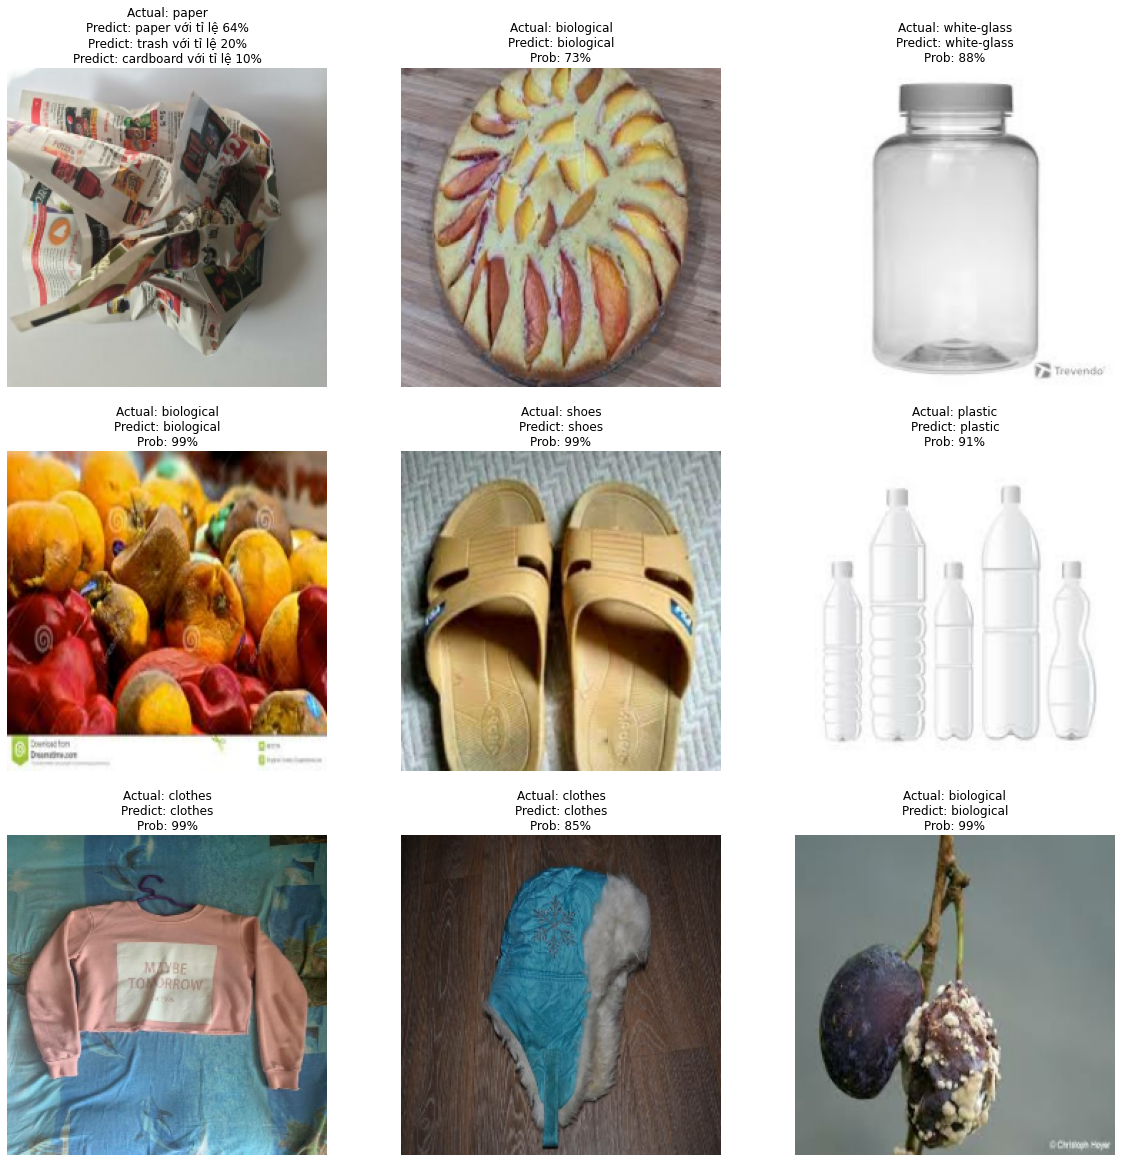

In [ ]:
# Kiểm tra mô hình
from keras.preprocessing import image
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1): 
  for i in range(9): # lấy ngẫu nhiên 9 ảnh từ tập test
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8")) 
    img_tensor = tf.keras.utils.img_to_array(images[i]) # chuyển ảnh sang dạng  3 ma trận 2 chiều                  
    img_tensor = np.expand_dims(img_tensor, axis=0) # chuyển thành 1 ma trận 3 chiều     
    x=newModel.predict(img_tensor) #mô hình dự đoán kết quả
    print("np.argmax(x)="+ str(np.argmax(x)))
    print(x)
    if (int(100*np.max(x))) < 70 :
      sort_x= np.argsort(x)[::-1]
      print(x[0][sort_x[0][11]])
      plt.title("Actual: "+class_names[labels[i]]+"\nPredict: "+class_names[sort_x[0][11]]+" với tỉ lệ "+str(int(100*x[0][sort_x[0][11]]))+'%' +"\nPredict: "+class_names[sort_x[0][10]]+" với tỉ lệ "+str(int(100*x[0][sort_x[0][10]]))+'%'+"\nPredict: "+class_names[sort_x[0][9]]+" với tỉ lệ "+str(int(100*x[0][sort_x[0][9]]))+'%')
    else: plt.title("Actual: "+class_names[labels[i]]+"\nPredict: "+class_names[np.argmax(x)]+"\nProb: "+str(int(100*np.max(x)))+'%') # so sánh kết quả  dự đoán và nhãn của ảnh
    plt.axis("off")

In [ ]:
# vẽ đồ thị thể hiện kết quả của model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.show()

NameError: ignored

In [ ]:
#lưu model
newModel.save('/content/drive/MyDrive/TriTueNhanTao/Garbage_Classify_VGG16.h5')